# Predicting House Price using a Linear Regression Model

Alexei Marcilio<br>
Nov 10, 2020<br>
Ver: 1.0

## Introduction

Ordinary Least Squares (OLS) regression is a closed-form and easily interpretable model used for predicting outcomes in
continuous data. It gives you the ability to clearly select the most powerful predictors of an outcome and make clear and actionable decisions based on those predictions.

### Regression Equation

A regression analysis yields an equation similar to the slope of a line, which is a mathematical representation of the shape of how your input variables predict your output variables. It's often presented as follows:

$Y = \alpha + \beta_1X_1 + \beta_2X_2 + e$

Y, representing a value for your outcome variable, is predicted by the slope of the line ($\alpha$) plus a coefficient, ($\beta$),
multiplied by each value $X$.

In [181]:
# Load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the housing data
#housing = pd.read_csv("house_data1.csv")
housing = pd.read_csv('housing_prices.csv')

# Explore the data
housing.head(5)
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [182]:
print(f"There are {housing.shape[0]} rows and {housing.shape[1]} columns \
in the housing dataset" )

There are 1460 rows and 81 columns in the housing dataset


## Feature Selection

Regression models are used to predict the slope of a line based on a certain target variable which is predicted by any number of feature variables. Features that are selected should have the following characteristics:
* **Strong** linear relationship with the target
* **Actionable** we should be able to say that changing a feature will have a specific impact on the price
* **Minimal** the model should only include as few features as necessary to draw strong conclusions
* **Independent** each feature should not be strongly correlated with each other.

### N/A values

In [183]:
# Let's check the housing data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

There are many columns that have mostly null values. Let's drop all columns with more than 20% missing data.

In [184]:
# Drop columns with more than 20% missing data
# thresh: Require that many non-NA values. 

housing.dropna(axis=1, thresh=int(housing.shape[0]*0.2), inplace=True)

### Categorical Values

As this is a linear model the input data needs to be continuous data or data with a limited number of categories. The categorical data can be converted in dummy variables.

In [185]:
# Let's check how many non-numeric have many unique values
housing_cts = housing.select_dtypes(include = 'object').agg(['count', 'nunique']).T
housing_cts.sort_values(by = ['nunique'], ascending = True).head(10)

,count,nunique
Street,1460,2
CentralAir,1460,2
Utilities,1460,2
GarageFinish,1379,3
LandSlope,1460,3
PavedDrive,1460,3
BsmtQual,1423,4
ExterQual,1460,4
MasVnrType,1452,4
KitchenQual,1460,4


There are quite a few columns with many non-unique values. Let's drop all the columns with more than 3 unique values.

In [186]:
housing.drop(columns=housing_cts[housing_cts['nunique'] > 3].index,axis=1,inplace=True)

In [187]:
print(f" We now have {housing.shape[1]} columns remaining.")

 We now have 44 columns remaining.


### Correlation of Features

Let's check how correlated the numeric features are to each other.

In [188]:
housing_corr = housing.select_dtypes(include = ['int64', 'float64']).corr()
np.round(housing_corr, 2)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.00,0.01,-0.01,-0.03,-0.03,0.01,-0.01,-0.02,-0.05,-0.01,...,-0.03,-0.00,0.00,-0.05,0.00,0.06,-0.01,0.02,0.00,-0.02
MSSubClass,0.01,1.00,-0.39,-0.14,0.03,-0.06,0.03,0.04,0.02,-0.07,...,-0.01,-0.01,-0.01,-0.04,-0.03,0.01,-0.01,-0.01,-0.02,-0.08
LotFrontage,-0.01,-0.39,1.00,0.43,0.25,-0.06,0.12,0.09,0.19,0.23,...,0.09,0.15,0.01,0.07,0.04,0.21,0.00,0.01,0.01,0.35
LotArea,-0.03,-0.14,0.43,1.00,0.11,-0.01,0.01,0.01,0.10,0.21,...,0.17,0.08,-0.02,0.02,0.04,0.08,0.04,0.00,-0.01,0.26
OverallQual,-0.03,0.03,0.25,0.11,1.00,-0.09,0.57,0.55,0.41,0.24,...,0.24,0.31,-0.11,0.03,0.06,0.07,-0.03,0.07,-0.03,0.79
OverallCond,0.01,-0.06,-0.06,-0.01,-0.09,1.00,-0.38,0.07,-0.13,-0.05,...,-0.00,-0.03,0.07,0.03,0.05,-0.00,0.07,-0.00,0.04,-0.08
YearBuilt,-0.01,0.03,0.12,0.01,0.57,-0.38,1.00,0.59,0.32,0.25,...,0.22,0.19,-0.39,0.03,-0.05,0.00,-0.03,0.01,-0.01,0.52
YearRemodAdd,-0.02,0.04,0.09,0.01,0.55,0.07,0.59,1.00,0.18,0.13,...,0.21,0.23,-0.19,0.05,-0.04,0.01,-0.01,0.02,0.04,0.51
MasVnrArea,-0.05,0.02,0.19,0.10,0.41,-0.13,0.32,0.18,1.00,0.26,...,0.16,0.13,-0.11,0.02,0.06,0.01,-0.03,-0.01,-0.01,0.48
BsmtFinSF1,-0.01,-0.07,0.23,0.21,0.24,-0.05,0.25,0.13,0.26,1.00,...,0.20,0.11,-0.10,0.03,0.06,0.14,0.00,-0.02,0.01,0.39


This is a rather large table so let's look at all the correlations with the SalePrice column and sort the values descending.

In [189]:
housing_sales_corr = housing_corr['SalePrice'].sort_values(ascending=False)

In [190]:
# Let's examine all the features which have a correlation of over 0.6 to SalesPrice
housing_sales_corr[housing_sales_corr > 0.6]

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64

There are 6 features that are highly correlated to SalesPrice - let's drop these columns.

In [191]:
housing.drop(['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF'], axis=1, inplace=True)

Let's check which features are highly correlated with each other

In [192]:
df_corr = housing.corr()

In [193]:
df_corr['YearBuilt']

Id              -0.012713
MSSubClass       0.027850
LotFrontage      0.123349
LotArea          0.014228
OverallCond     -0.375983
YearBuilt        1.000000
YearRemodAdd     0.592855
MasVnrArea       0.315707
BsmtFinSF1       0.249503
BsmtFinSF2      -0.049107
BsmtUnfSF        0.149040
2ndFlrSF         0.010308
LowQualFinSF    -0.183784
BsmtFullBath     0.187599
BsmtHalfBath    -0.038162
FullBath         0.468271
HalfBath         0.242656
BedroomAbvGr    -0.070651
KitchenAbvGr    -0.174800
TotRmsAbvGrd     0.095589
Fireplaces       0.147716
GarageYrBlt      0.825667
WoodDeckSF       0.224880
OpenPorchSF      0.188686
EnclosedPorch   -0.387268
3SsnPorch        0.031355
ScreenPorch     -0.050364
PoolArea         0.004950
MiscVal         -0.034383
MoSold           0.012398
YrSold          -0.013618
SalePrice        0.522897
Name: YearBuilt, dtype: float64

GarageYrBlt is highly correlated with YearBuild so we can drop GarageYrBlt

In [194]:
housing.drop('GarageYrBlt', axis=1, inplace=True)

### Remove columns that are not actionable

As you cannot change the slope of the land, the utility company, or the pavement of the street we will
drop these columns.

In [195]:
housing.drop(['Street', 'Utilities', 'LandSlope'], axis = 'columns', inplace=True)

### Encoding Categorical Features

With some processing categorical features can be included as features in a linear model. To do this we use dummy encoding. It turns categorical columns into multiple binary (1-0) columns for each value of the column.

In [196]:
# Create dummy columns for the three object columns, remove the first value to keep k-1 values
housing = pd.get_dummies(housing, columns = ['GarageFinish','CentralAir', 'PavedDrive'], drop_first=True)

In [198]:
# Check out the new columns
housing.head(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,GarageFinish_RFn,GarageFinish_Unf,CentralAir_Y,PavedDrive_P,PavedDrive_Y
0,1,60,65.0,8450,5,2003,2003,196.0,706,0,...,0,0,2,2008,208500,1,0,1,0,1
1,2,20,80.0,9600,8,1976,1976,0.0,978,0,...,0,0,5,2007,181500,1,0,1,0,1
2,3,60,68.0,11250,5,2001,2002,162.0,486,0,...,0,0,9,2008,223500,1,0,1,0,1
3,4,70,60.0,9550,5,1915,1970,0.0,216,0,...,0,0,2,2006,140000,0,1,1,0,1
4,5,60,84.0,14260,5,2000,2000,350.0,655,0,...,0,0,12,2008,250000,1,0,1,0,1


In [210]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1460 non-null   int64  
 1   MSSubClass        1460 non-null   int64  
 2   LotFrontage       1201 non-null   float64
 3   LotArea           1460 non-null   int64  
 4   OverallCond       1460 non-null   int64  
 5   YearBuilt         1460 non-null   int64  
 6   YearRemodAdd      1460 non-null   int64  
 7   MasVnrArea        1452 non-null   float64
 8   BsmtFinSF1        1460 non-null   int64  
 9   BsmtFinSF2        1460 non-null   int64  
 10  BsmtUnfSF         1460 non-null   int64  
 11  2ndFlrSF          1460 non-null   int64  
 12  LowQualFinSF      1460 non-null   int64  
 13  BsmtFullBath      1460 non-null   int64  
 14  BsmtHalfBath      1460 non-null   int64  
 15  FullBath          1460 non-null   int64  
 16  HalfBath          1460 non-null   int64  


### Null Values

There are additional null values remaining for the columns LotFrontage and MasVnrArea. This will prevent the model from being created. Let's input those null values with mean() values.

In [211]:
housing['LotFrontage'].fillna(housing['LotFrontage'].mean(), inplace = True)
housing['MasVnrArea'].fillna(housing['MasVnrArea'].mean(), inplace = True)

## Model Creation

### Split Data into X and y frames

The next key step is to split our dataframe into separate X and y frames. 

In [213]:
X = housing.drop(['SalePrice'], axis='columns')

In [214]:
y = housing['SalePrice']

### Split Train and Test

In [215]:
# Using sklearn split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=25)

### Train the model

In [216]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

We can now train our linear regression by fitting the training dataset: X_train and y_train.

In [217]:
lr.fit(X_train, y_train)

LinearRegression()

In [220]:
# We can use the X_test set to compare to the actual values in the y_test. We can use this
# to determine the accuracy of the model
y_pred = lr.predict(X_test)

### Evaluating our Model

There are several ways to evaluate a model. Let's first use $R^2$. 

$R^2$ is
an measure of the percent of variability in the target explained by the model's features

In [221]:
training_score = lr.score(X_train, y_train)
print(training_score)

0.7631606819722973


The $R^2$ value is 0.76 which is quite good. It shows that 76% of the variability in the Sale Price of a home can be explained by out feature variables.

Let's also check the $R^2$ of the test data.

In [223]:
print(f"The R-squared value of the test data is {lr.score(X_test, y_test)}.")

The R-squared value of the test data is 0.6858630915368191.


68% is the $R^2$ value for the test data.

### Plotting the Predictions

Let's plot the relationship of our y_pred and y_test values. 

This can help in understanding 
where the predictions are accurate and where your model may not be as good.

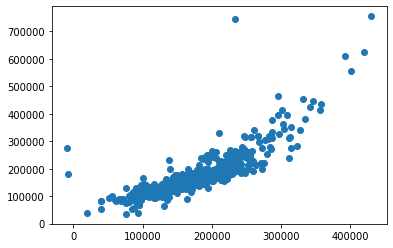

In [224]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(y_pred, y_test);

There seems to be a rather strong curvilinear relationship between the y_pred and y_test values.